<a href="https://colab.research.google.com/github/artaalikhani/fault_fcwt_CNN/blob/master/fcwt_cnn_SRM_fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import math
import pickle
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from fcwt import *
#import fcwt
import pywt
import time

import os
#os.chdir('C:/Users/artaa/Documents/ITSC_sim')

from Mchcnn2d import *



def normalise(spectra):
    if type(spectra) is np.ndarray:
        max_I = np.max(spectra)
        min_I = np.min(spectra)
    elif type(spectra) is torch.Tensor:
        max_I = max(spectra)
        min_I = min(spectra)
    spectra_normed = (spectra - min_I) / (max_I - min_I)
    return spectra_normed

def random_data_split(spectra, labels, settings):
    thresh1 = round(settings[0]*settings[5])
    thresh2 = round((settings[0] - thresh1)/2 + thresh1)
    l = list(range(settings[0]))
    if os.path.isfile('data_test_ind.csv'):
      lr = np.loadtxt('data_test_ind.csv', delimiter=",").astype(int)
    else:
      lr = random.sample(l, settings[0])
      np.savetxt('data_test_ind.csv',lr, delimiter=",")

    data_train = np.array([spectra[idx] for idx in lr[:thresh1]])
    data_val = np.array([spectra[idx] for idx in lr[thresh1:thresh2]])
    data_test = np.array([spectra[idx] for idx in lr[thresh2:]])
    labels_train = np.array([labels[idx] for idx in lr[:thresh1]])
    labels_val = np.array([labels[idx] for idx in lr[thresh1:thresh2]])
    labels_test = np.array([labels[idx] for idx in lr[thresh2:]])

    return (data_train, data_val, data_test), (labels_train, labels_val, labels_test)


class AugmentedDataset(Dataset):
    def __init__(self, tensors, settings, settings_aug):
        self.tensors = tensors
        self.settings = settings
        self.settings_aug = settings_aug

    def __getitem__(self, index):
        x = torch.from_numpy(np.asarray(self.tensors[0][index][:])).to(self.settings[4])
        y = torch.tensor(
            self.tensors[1][index].astype(np.float32)
        ).to(self.settings[4])
        return x, y

    def __len__(self):
        return len(self.tensors[0])

def AugmentedDataloader(spectra, labels, settings, settings_aug):
    tensors = (spectra, labels)
    #print('spectrashape',spectra.shape)
    ds = AugmentedDataset(
        tensors,
        settings,
        settings_aug,
    )
    loader = DataLoader(
        ds,
        batch_size=settings[6],
        shuffle=True,
        drop_last=True,
    )
    return loader

def dataloader_preparation(split_ratio=0.7, batch_size=50):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load dataset
    #spectra = normalise(xrd_datasets[0][:, np.newaxis, :])
    #labels = xrd_datasets[1]
    #loaded_arr = np.loadtxt("SFT_Data_sim_SVM_BLAC_Simple_STFT3.csv",delimiter=",")
    #loaded_arr = np.loadtxt("SFT_Data_simple.csv",delimiter=",")
    #Data = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] //51, 51)

    xrd_datasets1 = np.loadtxt('Vib_data2.csv',delimiter=",")
    xrd_datasets = xrd_datasets1[:,:]
    morl1 = Morlet(0.5)
    #morl2 = Morlet(4.0)
    #morl3 = Morlet(16.0)

    fn = 40
    f0 = 1
    f1 = 1500
    fs = 12000

    Data1=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
    #Data2=np.zeros([len(xrd_datasets[:,2400]),100,2400])
    #Data3=np.zeros([len(xrd_datasets[:,2400]),100,2400])
    spectra = []
    Class_label=np.zeros(len(xrd_datasets[:,2400]))
    t0 = time.time()
    for i in range(len(xrd_datasets[:,2400])):#
      fs=12000
      N_s=2400
      N_f=2400
      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]
      '''

      #############################tuned settings fCWT##########################


      for j in range(fn):
        BW = 0.2*(j+1)
        morl1 = Morlet(BW)
        out = np.zeros((2,len(x)), dtype='csingle')
        freqs = np.zeros((2), dtype='single')
        scales = Scales(morl1,FCWT_LOGSCALES,fs,(j+1)*30,(j+2)*30,2)
        scales.getFrequencies(freqs)
        fcwt = FCWT(morl1, 7, False, False)

        fcwt.cwt(x, scales, out)
        Data1[i,j,:] = abs(out[0,:])

      '''
      '''
      ####################CONVENTIONAL tuned settings fCWT######################


      BW = 4
      morl1 = Morlet(BW)
      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl1,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl1, 8, False, False)

      fcwt.cwt(x, scales, out)
      Data1[i,:,:] = abs(out)

      '''
      '''
      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl2,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl2, 8, False, False)

      fcwt.cwt(x, scales, out)
      Data2[i,:,:] = abs(out)

      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl3,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl3, 8, False, False)

      fcwt.cwt(x, scales, out)
      Data3[i,:,:] = abs(out)
      '''
      '''
      for j in range(19):
        idx = np.arange(j*30+28,j*30+32)
        Data[i,j*5:j*5+4,:]=np.abs(out[idx,:])
      '''
      '''
      ##################################fCWT####################################
      signal_CWRU=xrd_datasets[i,0:N_s]
      class_n=xrd_datasets[i,2400]
      freqs, coef=fcwt.cwt(signal_CWRU,12000,1,500,20)
      Data[i,:,:]=coef
      '''
      '''
      #############################Conventional CWT#############################
      signal_CWRU=xrd_datasets[i,0:N_s]
      class_n=xrd_datasets[i,2400]

      coef, freqs=pywt.cwt(signal_CWRU,np.arange(1,41),'cmor4-1')
      Data1[i,:,:]=coef
      '''
      Class_label[i]=class_n
    print('Signal processing time is:'+str(time.time()-t0))
    spectra = Data1[:,np.newaxis,:,:]
    #spectra = np.append(spectra,Data2[:,np.newaxis,:,:],axis=1)
    #spectra = np.append(spectra,Data3[:,np.newaxis,:,:],axis=1)
    '''
    ############################################################################
    f0 = 1
    f1 = 1000

    Data=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
    Class_label=np.zeros(len(xrd_datasets[:,2400]))
    for i in range(len(xrd_datasets[:,2400])):#
      fs=12000
      N_s=2400
      N_f=2400

      #############################tuned settings fCWT##########################
      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]

      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl, 8, True, False)

      fcwt.cwt(x, scales, out)

      Data[i,:,:]=abs(out)
      Class_label[i]=class_n
    spectra = np.append(spectra,Data[:,np.newaxis,:,:],axis=1)

    ############################################################################
    f0 = 1
    f1 = 5000

    Data=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
    Class_label=np.zeros(len(xrd_datasets[:,2400]))
    for i in range(len(xrd_datasets[:,2400])):#
      fs=12000
      N_s=2400
      N_f=2400

      #############################tuned settings fCWT##########################
      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]

      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl, 8, True, False)

      fcwt.cwt(x, scales, out)

      Data[i,:,:]=abs(out)
      Class_label[i]=class_n
    spectra = np.append(spectra,Data[:,np.newaxis,:,:],axis=1)
    ############################################################################
    '''
    #labels = np.loadtxt("Class_label_SVM_BLAC_test.csv",delimiter=',')
    #labels = np.loadtxt("Class_label_specto_simple.csv",delimiter=',')
    labels = Class_label
    # measure the numbers of dataset shape
    n_samples, n_channel, n_length,_ = spectra.shape
    n_class = len(np.unique(labels))
    settings = (n_samples, n_channel, n_length, n_class, device, split_ratio, batch_size)
    settings_aug = (100, 120, 0.2, 0.2, 0.5)
    # (window size, max peak shift size, probability of peak elimination,
    #  probability of peak scailing, probability of peak shift)

    # dataloaders
    spectra_split, labels_split = random_data_split(spectra, labels, settings)
    dataloader_train = AugmentedDataloader(
        spectra_split[0],
        labels_split[0],
        settings,
        settings_aug,
    )

    dataloader_val = DataLoader(
        MyDataset(spectra_split[1],labels_split[1]),
        batch_size=settings[6],
        #drop_last=True,
    )

    dataloader_test = DataLoader(
        MyDataset(spectra_split[2],labels_split[2]),
        batch_size=settings[6],
        #drop_last=True,
    )

    # compile dataloaders and settings
    dataloaders = (dataloader_train, dataloader_val, dataloader_test)
    return dataloaders, settings

def load_model(settings):

    #model = MSResNet(input_channel=1,layers=[4,2,5], num_classes=4)

    model = Net(in_channels=1,
                   n_class=12,##################################################################
                  )

    model.to(settings[4])
    model=model.double()
    return model

def top_k(pred, label, k:int = 1):
    labels_dim = 1
    k_labels = torch.topk(input=pred, k=k, dim=1, largest=True, sorted=True)[1]
    a = ~torch.prod(
        input = torch.abs(label.unsqueeze(labels_dim) - k_labels),
        dim=labels_dim,
    ).to(torch.bool)
    a = a.to(torch.int8)
    y_pred = a * label + (1-a) * k_labels[:,0]
    acc = accuracy_score(y_pred.cpu(), label.cpu())*100
    return acc

def record_learning_curve(lc_name, epoch, results, loss_train, acc_train, loss_val, acc_val):
    results[epoch, :] = np.array([loss_train, acc_train, loss_val, acc_val])
    df = pd.DataFrame(results, columns=['loss_train', 'acc_train', 'loss_val', 'acc_val'])
    df.to_csv(lc_name)

def save_model(best_acc, epoch, model):
    print('--------> The best model has been replaced.')
    print('epoch: '+str(epoch)+' | best_acc: '+str(best_acc))
    model_path = './wdcnn2d_epoch_CWRU'+str(epoch)+'.pt'
    torch.save(model.state_dict(), model_path)
    print('The best model has been saved in '+model_path)

def train(dataloaders, settings, model, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    model.train()
    model.zero_grad()

    for batch_idx, batch in enumerate(dataloaders[0]):
        # train
        input, label = tuple(t.to(settings[4]) for t in batch)
        label = label.long()
        pred = model(input)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # evaluate
        running_corrects += top_k(pred, label, k=1) * len(label)
        running_loss += loss.item()
        print('[Train] batch: '+str(batch_idx+1)+' | loss: '+str(loss.item()))

    # summarise
    n_train = round(settings[0] * settings[5])
    epoch_loss = running_loss / n_train
    epoch_acc = running_corrects / n_train
    print('[Train total] loss: '+str(epoch_loss)+' | acc: '+str(epoch_acc))
    return epoch_loss, epoch_acc

def val(dataloader, settings, model, criterion):
    running_loss = 0.0
    running_corrects = 0.0
    model.eval()
    model.zero_grad()

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            # test
            input, label = tuple(t.to(settings[4]) for t in batch)
            label = label.long()
            model=model.to(settings[4])
            pred = model(input.double())
            loss = criterion(pred, label)

            # evaluate
            running_corrects += top_k(pred, label, k=1) * len(label)
            running_loss += loss.item()
            print('[Val] batch: '+str(batch_idx+1)+' | loss: '+str(loss.item()))

    # summarise
    n_test = round(settings[0] * (1 - settings[5])/2)
    epoch_loss = running_loss / n_test
    epoch_acc = running_corrects / n_test
    print('[Val total] loss: '+str(epoch_loss)+' | acc: '+str(epoch_acc))
    return epoch_loss, epoch_acc

if __name__ == '__main__':
    lc_name = 'learning_curve_Mch_lstm_CNN2D_CWRU_fcwt.csv'
    n_epoch = 50
    batch = 14

    dataloaders, settings = dataloader_preparation(batch_size=batch)
    model = load_model(settings)
    criterion = nn.CrossEntropyLoss().to(settings[4])
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    '''
    from torchsummary import summary
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    summary(model.to(device=device, dtype=torch.float),(1,10,51))
    '''
    best_acc = 0.0
    results = np.zeros([n_epoch, 4])
    for epoch in range(n_epoch):
        print('>>>>>> epoch '+str(epoch)+' starts')
        model=model.double()
        model.eval()
        loss_train, acc_train = train(dataloaders, settings, model, criterion, optimizer)
        loss_val, acc_val = val(dataloaders[1], settings, model, criterion)
        record_learning_curve(lc_name,epoch,results,loss_train,acc_train,loss_val,acc_val)

        # save better model
        if best_acc <= acc_val:
            best_acc = acc_val
            loss_test, acc_test = val(dataloaders[2], settings, model, criterion)

            #if epoch>10:
            #save_model(best_acc, epoch, model)


C:\Users\artaa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Signal processing time is:59.6892991065979


C:\Users\artaa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


>>>>>> epoch 0 starts
[Train] batch: 1 | loss: 2.674809371723716
[Train] batch: 2 | loss: 2.3136332013587095
[Train] batch: 3 | loss: 2.358745107805398
[Train] batch: 4 | loss: 2.2013469600994364
[Train] batch: 5 | loss: 2.4026490767560063
[Train] batch: 6 | loss: 2.397490513560814
[Train] batch: 7 | loss: 2.3207586522327874
[Train] batch: 8 | loss: 2.0300888369143886
[Train] batch: 9 | loss: 2.0321716155890686
[Train] batch: 10 | loss: 2.1113410341197225
[Train] batch: 11 | loss: 1.9117288101499013


KeyboardInterrupt: ignored

In [ ]:
save_model(best_acc, epoch, model)

--------> The best model has been replaced.
epoch: 49 | best_acc: 100.0
The best model has been saved in ./wdcnn2d_epoch_CWRU49.pt


In [ ]:
from Mchcnn2d import *
model = load_model(settings)
criterion = nn.CrossEntropyLoss().to(settings[4])
optimizer = optim.SGD(model.parameters(), lr=0.001)
best_acc = 0.0
results = np.zeros([n_epoch, 4])
for epoch in range(n_epoch):
        print('>>>>>> epoch '+str(epoch)+' starts')
        model=model.double()
        model.eval()
        loss_train, acc_train = train(dataloaders, settings, model, criterion, optimizer)
        loss_val, acc_val = val(dataloaders[1], settings, model, criterion)
        record_learning_curve(lc_name,epoch,results,loss_train,acc_train,loss_val,acc_val)

        # save better model
        if best_acc <= acc_val:
            best_acc = acc_val
            loss_test, acc_test = val(dataloaders[2], settings, model, criterion)

In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
summary(model.to(device=device, dtype=torch.float),(1,40,2400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 40, 2400]               2
            Conv2d-2           [-1, 4, 10, 150]             340
       BatchNorm2d-3           [-1, 4, 10, 150]               8
        BasicBlock-4           [-1, 4, 10, 150]               0
            Conv2d-5           [-1, 4, 10, 150]             144
       BatchNorm2d-6           [-1, 4, 10, 150]               8
        BasicBlock-7           [-1, 4, 10, 150]               0
            Conv2d-8           [-1, 4, 10, 150]             144
       BatchNorm2d-9           [-1, 4, 10, 150]               8
       BasicBlock-10           [-1, 4, 10, 150]               0
           Conv2d-11           [-1, 4, 10, 150]             144
      BatchNorm2d-12           [-1, 4, 10, 150]               8
       BasicBlock-13           [-1, 4, 10, 150]               0
     CascadeBlock-14          [-1, 16, 

# FCWT

In [ ]:
import numpy as np
from fcwt import *
#import fcwt
import pywt
import time


xrd_datasets1 = np.loadtxt('Vib_data2.csv',delimiter=",")
xrd_datasets = xrd_datasets1[:,:]

fn = 50
f0 = 1
f1 = 1500
fs = 12000

Data1=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
spectra = []
Class_label=np.zeros(len(xrd_datasets[:,2400]))
t0 = time.time()
for i in range(740):#len(xrd_datasets[:,2400])
      fs=12000
      N_s=2400
      N_f=2400
      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]
      #'''

      #############################tuned settings fCWT##########################


      for j in range(fn):
        BW = 0.3*(j+1)
        morl1 = Morlet(BW)
        out = np.zeros((2,len(x)), dtype='csingle')
        freqs = np.zeros((2), dtype='single')
        scales = Scales(morl1,FCWT_LOGSCALES,fs,(j+1)*30,(j+2)*30,2)
        scales.getFrequencies(freqs)
        fcwt = FCWT(morl1, 8, False, False)

        fcwt.cwt(x, scales, out)
        Data1[i,j,:] = abs(out[0,:])


delta_t = time.time()-t0
print(delta_t)

4.0


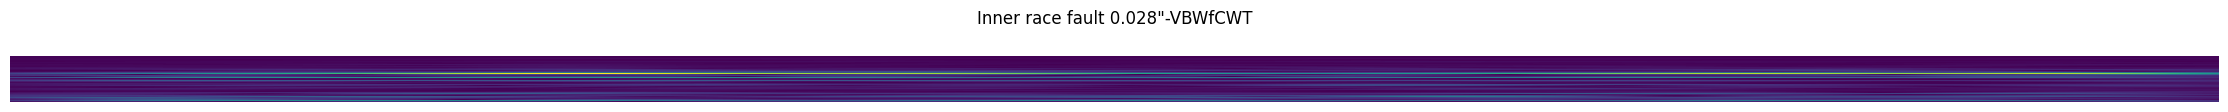

In [ ]:
import numpy as np
from fcwt import *
#import fcwt
import pywt
import time

xrd_datasets = np.loadtxt('Vib_data2.csv',delimiter=",")

morl = Morlet(4)

fn = 50
f0 = 1
f1 = 1500
fs = 12000

Data3=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
Class_label=np.zeros(len(xrd_datasets[:,2400]))
t0 = time.time()
for i in range(740):#len(xrd_datasets[:,2400])
      fs=12000
      N_s=2400
      N_f=2400
      #'''
      #############################tuned settings fCWT##########################
      signal_CWRU=xrd_datasets[i,0:N_s]
      class_n=xrd_datasets[i,2400]

      coef, freqs=pywt.cwt(signal_CWRU,np.arange(1,51),'gaus1')
      Data3[i,:,:]=coef
      '''
      for j in range(19):
        idx = np.arange(j*25+23,j*25+27)
        Data[i,j*5:j*5+4,:]=np.abs(out[idx,:])

      '''

delta_t = time.time()-t0
print(delta_t)idx = 280

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 10.5)
ax.matshow(Data1[idx,:,:])
ax.set_axis_off()
ax.set_title('Inner race fault 0.028"-VBWfCWT')
print(Class_label[idx])


4.0


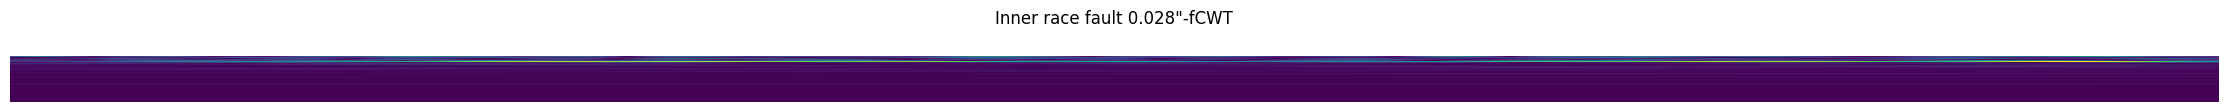

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(28.5, 10.5)
ax.matshow(Data2[idx,:,:])
ax.set_axis_off()
ax.set_title('Inner race fault 0.028"-fCWT')
print(Class_label[idx])

In [ ]:
Data[1,:,:]

array([[-2.37412286e+00, -2.87331581e+00, -3.17662501e+00, ...,
         2.35136509e+00,  5.91339111e+00,  9.06126499e+00],
       [-2.98677540e+01, -3.13147697e+01, -3.16530914e+01, ...,
        -3.16987991e+00, -7.99067116e+00, -1.25119534e+01],
       [-2.57952332e+00, -1.47910953e+00, -3.48862648e-01, ...,
         1.11665211e+01,  1.19044638e+01,  1.24203091e+01],
       ...,
       [-9.12370735e-11, -9.11569917e-11, -9.10715531e-11, ...,
        -8.60810728e-11, -8.63230112e-11, -8.65598912e-11],
       [-9.12370735e-11, -9.11569917e-11, -9.10715531e-11, ...,
        -8.60810728e-11, -8.63230112e-11, -8.65598912e-11],
       [-9.12370735e-11, -9.11569917e-11, -9.10715531e-11, ...,
        -8.60810728e-11, -8.63230112e-11, -8.65598912e-11]])

In [ ]:
def save_model(best_acc, epoch, model):
    print('--------> The best model has been replaced.')
    print('epoch: '+str(epoch)+' | best_acc: '+str(best_acc))
    model_path = './wdcnn2d_epoch_CWRU_fcwt_conventional'+str(epoch)+'.pt'
    torch.save(model.state_dict(), model_path)
    print('The best model has been saved in '+model_path)
save_model(best_acc, epoch, model)

--------> The best model has been replaced.
epoch: 49 | best_acc: 100.0
The best model has been saved in ./wdcnn2d_epoch_CWRU_final_final49.pt


#load model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import math
import pickle
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import math
import scipy.io
from scipy import signal
from fcwt import *
#import fcwt
import pywt


import os
os.chdir('C:/Users/artaa/Documents/ITSC_sim')

from Mchcnn2d_new import *
#from wdcnn import *

def random_data_split(spectra, labels, settings):
    thresh1 = round(settings[0]*settings[5])
    thresh2 = round((settings[0] - thresh1)/2 + thresh1)
    l = list(range(settings[0]))
    lr = random.sample(l, settings[0])
    ind = np.loadtxt('data_test_ind_main.csv', delimiter=",")
    ind = np.loadtxt('data_test_ind.csv', delimiter=",")
    data_train = np.array([spectra[idx] for idx in lr[:thresh1]])
    data_val = np.array([spectra[idx] for idx in lr[thresh1:thresh2]])
    data_test = np.array([spectra[idx] for idx in ind[thresh2:].astype(int)])
    labels_train = np.array([labels[idx] for idx in lr[:thresh1]])
    labels_val = np.array([labels[idx] for idx in lr[thresh1:thresh2]])
    labels_test = np.array([labels[idx] for idx in ind[thresh2:].astype(int)])

    return (data_train, data_val, data_test), (labels_train, labels_val, labels_test)
class AugmentedDataset(Dataset):
    def __init__(self, tensors, settings, settings_aug):
        self.tensors = tensors
        self.settings = settings
        self.settings_aug = settings_aug

    def __getitem__(self, index):
        x = torch.from_numpy(np.asarray(self.tensors[0][index][:])).to(self.settings[4])
        y = torch.tensor(
            self.tensors[1][index].astype(np.float32)
        ).to(self.settings[4])
        return x, y

    def __len__(self):
        return len(self.tensors[0])
def AugmentedDataloader(spectra, labels, settings, settings_aug):
    tensors = (spectra, labels)
    #print('spectrashape',spectra.shape)
    ds = AugmentedDataset(
        tensors,
        settings,
        settings_aug,
    )
    loader = DataLoader(
        ds,
        batch_size=settings[6],
        shuffle=True,
        drop_last=True,
    )
    return loader
def dataloader_preparation(split_ratio=0.7, batch_size=50, noise_std=0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    xrd_datasets1 = np.loadtxt('Vib_data2.csv',delimiter=",")
    ind = np.loadtxt('data_test_ind.csv', delimiter=",")
    xrd_datasets = xrd_datasets1[:,:]
    morl = Morlet(4.0)

    fn = 50
    f0 = 1
    f1 = 1200
    fs = 12000

    Data1=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
    #Data2=np.zeros([len(xrd_datasets[:,2400]),100,2400])
    #Data3=np.zeros([len(xrd_datasets[:,2400]),100,2400])
    spectra = []
    Class_label=np.zeros(len(xrd_datasets[:,2400]))
    for i in range(len(xrd_datasets[:,2400])):#
      fs=12000
      N_s=2400
      N_f=2400
      #'''
      #############################tuned settings fCWT##########################
      x=xrd_datasets[i,0:N_s].astype('single')+np.random.normal(0,noise_std,N_s).astype('single')#+np.sin(np.linspace(0,2400,2400)*np.pi/180*20/12000).astype('single')
      class_n=xrd_datasets[i,2400]

      for j in range(fn):
        BW = 0.3*(j+1)
        morl1 = Morlet(BW)
        out = np.zeros((2,len(x)), dtype='csingle')
        freqs = np.zeros((2), dtype='single')
        scales = Scales(morl1,FCWT_LOGSCALES,fs,(j+1)*30,(j+2)*30,2)
        scales.getFrequencies(freqs)
        fcwt = FCWT(morl1, 8, False, False)

        fcwt.cwt(x, scales, out)
        Data1[i,j,:] = abs(out[0,:])
      Class_label[i]=class_n

    spectra=Data1[:,np.newaxis,:,:]
    labels = Class_label

    # measure the numbers of dataset shape
    n_samples, n_channel, n_length,_ = spectra.shape
    n_class = len(np.unique(labels))
    settings = (n_samples, n_channel, n_length, n_class, device, split_ratio, batch_size)
    settings_aug = (100, 120, 0.2, 0.2, 0.5)
    # (window size, max peak shift size, probability of peak elimination,
    #  probability of peak scailing, probability of peak shift)


    # dataloaders
    spectra_split, labels_split = random_data_split(spectra, labels, settings)
    dataloader_train = AugmentedDataloader(
        spectra_split[0],
        labels_split[0],
        settings,
        settings_aug,
    )

    dataloader_val = DataLoader(
        MyDataset(spectra_split[1],labels_split[1]),
        batch_size=settings[6],
        #drop_last=True,
    )

    dataloader_test = DataLoader(
        MyDataset(spectra_split[2],labels_split[2]),
        batch_size=settings[6],
        #drop_last=True,
    )

    # compile dataloaders and settings
    dataloaders = (dataloader_train, dataloader_val, dataloader_test)
    return dataloaders, settings
def load_model(settings):

    #model = MSResNet(input_channel=1,layers=[4,2,5], num_classes=4)

    model = Net(in_channels=1,
                   n_class=12,
                  )

    model.to(settings[4])
    model=model.double()
    return model

def top_k(pred, label, k:int = 1):
    labels_dim = 1
    k_labels = torch.topk(input=pred, k=k, dim=1, largest=True, sorted=True)[1]
    a = ~torch.prod(
        input = torch.abs(label.unsqueeze(labels_dim) - k_labels),
        dim=labels_dim,
    ).to(torch.bool)
    a = a.to(torch.int8)
    y_pred = a * label + (1-a) * k_labels[:,0]
    acc = accuracy_score(y_pred.cpu(), label.cpu())*100
    print(confusion_matrix(label.cpu(), y_pred.cpu()))
    return acc
def val(dataloader, settings, model, criterion):
    running_loss = 0.0
    running_corrects = 0.0
    model.eval()
    model.zero_grad()

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            # test
            input, label = tuple(t.to(settings[4]) for t in batch)
            label = label.long()
            model=model.to(settings[4])
            pred = model(input.double())
            loss = criterion(pred, label)

            # evaluate
            running_corrects += top_k(pred, label, k=1) * len(label)
            running_loss += loss.item()
            print('[Val] batch: '+str(batch_idx+1)+' | loss: '+str(loss.item()))
    # summarise
    n_test = 555#round(settings[0] * (1 - settings[5])/2)
    epoch_loss = running_loss / n_test
    epoch_acc = running_corrects / n_test
    print('[Val total] loss: '+str(epoch_loss)+' | acc: '+str(epoch_acc))
    return epoch_loss, epoch_acc

C:\Users\artaa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
batch = 200

dataloaders, settings = dataloader_preparation(batch_size=batch,noise_std=0)

model = load_model(settings)
model=model.double()
#model.load_state_dict(torch.load('Results_wdcnn/wdcnn1d_epoch261_wdcnn_mod.pt'))
#model.load_state_dict(torch.load('Results_mlwdcnn/wdcnn1d_epoch199.pt'))
criterion = nn.CrossEntropyLoss().to(settings[4])
model.load_state_dict(torch.load('wdcnn2d_epoch_CWRU_final_final49.pt'))
loss_val, acc_val = val(dataloaders[2], settings, model, criterion)

C:\Users\artaa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[[36  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  1  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  8  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 12  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 35]]
[Val] batch: 1 | loss: 0.09338184886902268
[[43  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 39  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 24]]
[Val] batch: 2 | lo

#plot data

In [ ]:
mat = scipy.io.loadmat('itsc_fault_data_MC_test_SVM_BLAC_test8.mat')
Iq_csv = mat['Iq_csv']
xrd_datasets1 = Iq_csv
spectra_plt=xrd_datasets1[:,0:500]

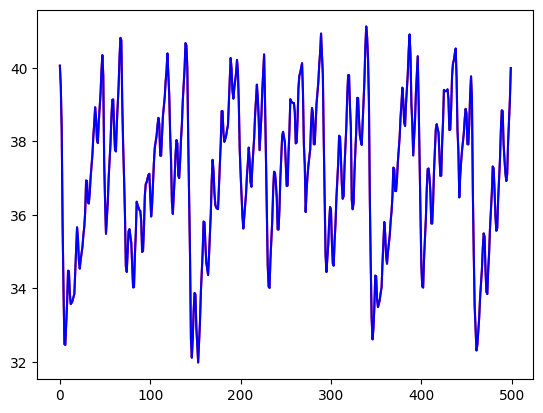

In [ ]:
import matplotlib.pyplot as plt
plt.plot(spectra_plt[2100,:]+np.random.normal(0,2.2,500),'r')
plt.plot(spectra_plt[2100,:],'b')

#plt.xlim([250,280])

In [ ]:
Psig = np.var(spectra_plt[2100,:])
noise = np.random.laplace(0,6,500)
Pnos=np.var(noise)

SNR=10*np.log10(Psig/Pnos)
print("SNR = "+str(SNR))

SNR = -12.471718491274263


In [ ]:
save_model(best_acc, epoch, model)

--------> The best model has been replaced.
epoch: 262 | best_acc: 99.39393939393939
The best model has been saved in ./wdcnn1d_epoch262.pt


In [ ]:
pip install torchmetrics

In [ ]:
pip install pytorch_lightning

In [ ]:
import matplotlib.pyplot as plt

import os
os.chdir('/content/gdrive/My Drive/ResNet')
import numpy as np
xrd_datasets = np.loadtxt('Vib_data2.csv',delimiter=",")

#spectra=xrd_datasets[:,0:2400]
labels = xrd_datasets[:,12000]
#print(spectra.shape)
#plt.plot(spectra[10,:])
A=xrd_datasets[:,0:2400]
for i in range(4):
    A=np.append(A,xrd_datasets[:,2400*(i+1):2400*(i+2)],axis=0)

B_prim=xrd_datasets[:,12000]
B=[]
for i in range(5):
    B=np.append(B,B_prim,axis=0)
print(B.shape)
B = np.reshape(B, (-1, 1))
A=np.append(A,B,axis=1)
print(A.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.chdir('/content/drive/My Drive/ITSC fault')
df = pd.read_csv('learning_curve_PRO.csv', header= 'infer', sep=',')
acc_loss=df.to_numpy()
df2 = pd.read_csv('learning_curve_RESNET.csv', header= 'infer', sep=',')
acc_loss2=df2.to_numpy()
#acc_loss = np.loadtxt('learning_curve_PRO.csv',delimiter=",")
plt.rcParams['font.serif'] = "Times New Roman"

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}
plt.rcdefaults()
plt.rc('font', **font)

plt.plot(acc_loss[0:21,1],label='Proposed')
plt.plot(acc_loss2[0:21,1],'r--',label='1D-ResNet')
plt.xlim([0, 20])
#plt.ylim([0, 0.02])
plt.xticks(np.arange(0, 19, step=2),np.arange(0, 20, step=2))
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("Training Loss")
plt.grid()
plt.figure(2)
plt.plot(acc_loss[0:21,2],label='Proposed')
plt.plot(acc_loss2[0:21,2],'r--',label='1D-ResNet')
plt.xlim([0, 20])
#plt.ylim([70, 105])
plt.xticks(np.arange(0, 19, step=2),np.arange(0, 20, step=2))
plt.legend(loc="center right")
plt.xlabel("epoch")
plt.ylabel("Training Accuracy (%)")
plt.grid()
plt.figure(3)
plt.plot(acc_loss[0:21,4],label='Proposed')
plt.plot(acc_loss2[0:21,4],'r--',label='1D-ResNet')
plt.xlim([0, 20])
#plt.ylim([70, 105])
plt.xticks(np.arange(0, 19, step=2),np.arange(0, 20, step=2))
plt.legend(loc="center right")
plt.xlabel("epoch")
plt.ylabel("Validation Accuracy (%)")
plt.grid()

#STFT training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import math
import pickle
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from fcwt import *
#import fcwt
import pywt
import time
from scipy import signal

import os
#os.chdir('C:/Users/artaa/Documents/ITSC_sim')

from Mchcnn2d import *



def normalise(spectra):
    if type(spectra) is np.ndarray:
        max_I = np.max(spectra)
        min_I = np.min(spectra)
    elif type(spectra) is torch.Tensor:
        max_I = max(spectra)
        min_I = min(spectra)
    spectra_normed = (spectra - min_I) / (max_I - min_I)
    return spectra_normed

def random_data_split(spectra, labels, settings):
    thresh1 = round(settings[0]*settings[5])
    thresh2 = round((settings[0] - thresh1)/2 + thresh1)
    l = list(range(settings[0]))
    if os.path.isfile('data_test_ind.csv'):
      lr = np.loadtxt('data_test_ind.csv', delimiter=",").astype(int)
    else:
      lr = random.sample(l, settings[0])
      np.savetxt('data_test_ind.csv',lr, delimiter=",")

    data_train = np.array([spectra[idx] for idx in lr[:thresh1]])
    data_val = np.array([spectra[idx] for idx in lr[thresh1:thresh2]])
    data_test = np.array([spectra[idx] for idx in lr[thresh2:]])
    labels_train = np.array([labels[idx] for idx in lr[:thresh1]])
    labels_val = np.array([labels[idx] for idx in lr[thresh1:thresh2]])
    labels_test = np.array([labels[idx] for idx in lr[thresh2:]])

    return (data_train, data_val, data_test), (labels_train, labels_val, labels_test)


class AugmentedDataset(Dataset):
    def __init__(self, tensors, settings, settings_aug):
        self.tensors = tensors
        self.settings = settings
        self.settings_aug = settings_aug

    def __getitem__(self, index):
        x = torch.from_numpy(np.asarray(self.tensors[0][index][:])).to(self.settings[4])
        y = torch.tensor(
            self.tensors[1][index].astype(np.float32)
        ).to(self.settings[4])
        return x, y

    def __len__(self):
        return len(self.tensors[0])

def AugmentedDataloader(spectra, labels, settings, settings_aug):
    tensors = (spectra, labels)
    #print('spectrashape',spectra.shape)
    ds = AugmentedDataset(
        tensors,
        settings,
        settings_aug,
    )
    loader = DataLoader(
        ds,
        batch_size=settings[6],
        shuffle=True,
        drop_last=True,
    )
    return loader

def dataloader_preparation(split_ratio=0.7, batch_size=50):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load dataset
    #spectra = normalise(xrd_datasets[0][:, np.newaxis, :])
    #labels = xrd_datasets[1]
    #loaded_arr = np.loadtxt("SFT_Data_sim_SVM_BLAC_Simple_STFT3.csv",delimiter=",")
    #loaded_arr = np.loadtxt("SFT_Data_simple.csv",delimiter=",")
    #Data = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] //51, 51)

    xrd_datasets1 = np.loadtxt('Vib_data2.csv',delimiter=",")
    xrd_datasets = xrd_datasets1[:,:]
    #morl1 = Morlet(0.5)
    #morl2 = Morlet(4.0)
    #morl3 = Morlet(16.0)
    fs = 12000
    freq_a = 60
    freq_i=freq_a/4
    N_s=2400
    N_f=2400//4
    NFFT=fs//freq_i
    NPSEG=NFFT//2
    NOVER=NPSEG-(N_s//1200)

    Data1=np.zeros([len(xrd_datasets[:,2400]),50,1201])
    #Data2=np.zeros([len(xrd_datasets[:,2400]),100,2400])
    #Data3=np.zeros([len(xrd_datasets[:,2400]),100,2400])
    spectra = []
    Class_label=np.zeros(len(xrd_datasets[:,2400]))

    t0 = time.time()
    for i in range(len(xrd_datasets[:,2400])):#

      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]

      ###################################STFT###################################
      f, t, Zxx = signal.stft(x , fs, nperseg=NPSEG, noverlap=NOVER, nfft=NFFT)
      Data1[i,:,:] = np.abs(Zxx[0:50])

      '''

      #############################tuned settings fCWT##########################


      for j in range(fn):
        BW = 0.3*(j+1)
        morl1 = Morlet(BW)
        out = np.zeros((2,len(x)), dtype='csingle')
        freqs = np.zeros((2), dtype='single')
        scales = Scales(morl1,FCWT_LOGSCALES,fs,(j+1)*30,(j+2)*30,2)
        scales.getFrequencies(freqs)
        fcwt = FCWT(morl1, 8, False, False)

        fcwt.cwt(x, scales, out)
        Data1[i,j,:] = abs(out[0,:])

      '''
      '''
      ####################CONVENTIONAL tuned settings fCWT######################


      BW = 4
      morl1 = Morlet(BW)
      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl1,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl1, 8, False, False)

      fcwt.cwt(x, scales, out)
      Data1[i,:,:] = abs(out)

      '''
      '''
      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl2,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl2, 8, False, False)

      fcwt.cwt(x, scales, out)
      Data2[i,:,:] = abs(out)

      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl3,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl3, 8, False, False)

      fcwt.cwt(x, scales, out)
      Data3[i,:,:] = abs(out)
      '''
      '''
      for j in range(19):
        idx = np.arange(j*30+28,j*30+32)
        Data[i,j*5:j*5+4,:]=np.abs(out[idx,:])
      '''
      Class_label[i]=class_n
      #'''
      '''
      ##################################fCWT####################################
      signal_CWRU=xrd_datasets[i,0:N_s]
      class_n=xrd_datasets[i,2400]
      freqs, coef=fcwt.cwt(signal_CWRU,12000,1,500,20)
      Data[i,:,:]=coef
      Class_label[i]=class_n
      '''
      '''
      #############################Conventional CWT#############################
      signal_CWRU=xrd_datasets[i,0:N_s]
      class_n=xrd_datasets[i,2400]

      coef, freqs=pywt.cwt(signal_CWRU,np.arange(1,51),'gaus1')
      Data1[i,:,:]=coef
      '''
    spectra = Data1[:,np.newaxis,:,:]
    #spectra = np.append(spectra,Data2[:,np.newaxis,:,:],axis=1)
    #spectra = np.append(spectra,Data3[:,np.newaxis,:,:],axis=1)
    '''
    ############################################################################
    f0 = 1
    f1 = 1000

    Data=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
    Class_label=np.zeros(len(xrd_datasets[:,2400]))
    for i in range(len(xrd_datasets[:,2400])):#
      fs=12000
      N_s=2400
      N_f=2400

      #############################tuned settings fCWT##########################
      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]

      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl, 8, True, False)

      fcwt.cwt(x, scales, out)

      Data[i,:,:]=abs(out)
      Class_label[i]=class_n
    spectra = np.append(spectra,Data[:,np.newaxis,:,:],axis=1)

    ############################################################################
    f0 = 1
    f1 = 5000

    Data=np.zeros([len(xrd_datasets[:,2400]),fn,2400])
    Class_label=np.zeros(len(xrd_datasets[:,2400]))
    for i in range(len(xrd_datasets[:,2400])):#
      fs=12000
      N_s=2400
      N_f=2400

      #############################tuned settings fCWT##########################
      x=xrd_datasets[i,0:N_s].astype('single')#+np.random.normal(0,.5,N_s).astype('single')
      class_n=xrd_datasets[i,2400]

      out = np.zeros((fn,len(x)), dtype='csingle')
      freqs = np.zeros((fn), dtype='single')
      scales = Scales(morl,FCWT_LOGSCALES,fs,f0,f1,fn)
      scales.getFrequencies(freqs)
      fcwt = FCWT(morl, 8, True, False)

      fcwt.cwt(x, scales, out)

      Data[i,:,:]=abs(out)
      Class_label[i]=class_n
    spectra = np.append(spectra,Data[:,np.newaxis,:,:],axis=1)
    ############################################################################
    '''
    #labels = np.loadtxt("Class_label_SVM_BLAC_test.csv",delimiter=',')
    #labels = np.loadtxt("Class_label_specto_simple.csv",delimiter=',')
    print('STFT time is:'+str(time.time()-t0))
    labels = Class_label
    # measure the numbers of dataset shape
    n_samples, n_channel, n_length,_ = spectra.shape
    n_class = len(np.unique(labels))
    settings = (n_samples, n_channel, n_length, n_class, device, split_ratio, batch_size)
    settings_aug = (100, 120, 0.2, 0.2, 0.5)
    # (window size, max peak shift size, probability of peak elimination,
    #  probability of peak scailing, probability of peak shift)

    # dataloaders
    spectra_split, labels_split = random_data_split(spectra, labels, settings)
    dataloader_train = AugmentedDataloader(
        spectra_split[0],
        labels_split[0],
        settings,
        settings_aug,
    )

    dataloader_val = DataLoader(
        MyDataset(spectra_split[1],labels_split[1]),
        batch_size=settings[6],
        #drop_last=True,
    )

    dataloader_test = DataLoader(
        MyDataset(spectra_split[2],labels_split[2]),
        batch_size=settings[6],
        #drop_last=True,
    )

    # compile dataloaders and settings
    dataloaders = (dataloader_train, dataloader_val, dataloader_test)
    return dataloaders, settings

def load_model(settings):

    #model = MSResNet(input_channel=1,layers=[4,2,5], num_classes=4)

    model = Net(in_channels=1,
                   n_class=12,##################################################################
                  )

    model.to(settings[4])
    model=model.double()
    return model

def top_k(pred, label, k:int = 1):
    labels_dim = 1
    k_labels = torch.topk(input=pred, k=k, dim=1, largest=True, sorted=True)[1]
    a = ~torch.prod(
        input = torch.abs(label.unsqueeze(labels_dim) - k_labels),
        dim=labels_dim,
    ).to(torch.bool)
    a = a.to(torch.int8)
    y_pred = a * label + (1-a) * k_labels[:,0]
    acc = accuracy_score(y_pred.cpu(), label.cpu())*100
    return acc

def record_learning_curve(lc_name, epoch, results, loss_train, acc_train, loss_val, acc_val):
    results[epoch, :] = np.array([loss_train, acc_train, loss_val, acc_val])
    df = pd.DataFrame(results, columns=['loss_train', 'acc_train', 'loss_val', 'acc_val'])
    df.to_csv(lc_name)

def save_model(best_acc, epoch, model):
    print('--------> The best model has been replaced.')
    print('epoch: '+str(epoch)+' | best_acc: '+str(best_acc))
    model_path = './wdcnn2d_epoch_CWRU'+str(epoch)+'.pt'
    torch.save(model.state_dict(), model_path)
    print('The best model has been saved in '+model_path)

def train(dataloaders, settings, model, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    model.train()
    model.zero_grad()

    for batch_idx, batch in enumerate(dataloaders[0]):
        # train
        input, label = tuple(t.to(settings[4]) for t in batch)
        label = label.long()
        pred = model(input)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # evaluate
        running_corrects += top_k(pred, label, k=1) * len(label)
        running_loss += loss.item()
        print('[Train] batch: '+str(batch_idx+1)+' | loss: '+str(loss.item()))

    # summarise
    n_train = round(settings[0] * settings[5])
    epoch_loss = running_loss / n_train
    epoch_acc = running_corrects / n_train
    print('[Train total] loss: '+str(epoch_loss)+' | acc: '+str(epoch_acc))
    return epoch_loss, epoch_acc

def val(dataloader, settings, model, criterion):
    running_loss = 0.0
    running_corrects = 0.0
    model.eval()
    model.zero_grad()

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            # test
            input, label = tuple(t.to(settings[4]) for t in batch)
            label = label.long()
            model=model.to(settings[4])
            pred = model(input.double())
            loss = criterion(pred, label)

            # evaluate
            running_corrects += top_k(pred, label, k=1) * len(label)
            running_loss += loss.item()
            print('[Val] batch: '+str(batch_idx+1)+' | loss: '+str(loss.item()))

    # summarise
    n_test = round(settings[0] * (1 - settings[5])/2)
    epoch_loss = running_loss / n_test
    epoch_acc = running_corrects / n_test
    print('[Val total] loss: '+str(epoch_loss)+' | acc: '+str(epoch_acc))
    return epoch_loss, epoch_acc

if __name__ == '__main__':
    lc_name = 'learning_curve_Mch_lstm_CNN2D_CWRU_stft.csv'
    n_epoch = 50
    batch = 14

    dataloaders, settings = dataloader_preparation(batch_size=batch)
    model = load_model(settings)
    criterion = nn.CrossEntropyLoss().to(settings[4])
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    '''
    from torchsummary import summary
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    summary(model.to(device=device, dtype=torch.float),(1,10,51))
    '''
    best_acc = 0.0
    results = np.zeros([n_epoch, 4])
    for epoch in range(n_epoch):
        print('>>>>>> epoch '+str(epoch)+' starts')
        model=model.double()
        model.eval()
        loss_train, acc_train = train(dataloaders, settings, model, criterion, optimizer)
        loss_val, acc_val = val(dataloaders[1], settings, model, criterion)
        record_learning_curve(lc_name,epoch,results,loss_train,acc_train,loss_val,acc_val)

        # save better model
        if best_acc <= acc_val:
            best_acc = acc_val
            loss_test, acc_test = val(dataloaders[2], settings, model, criterion)

            #if epoch>10:
            #save_model(best_acc, epoch, model)


C:\Users\artaa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


STFT time is:40.491140842437744


C:\Users\artaa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


>>>>>> epoch 0 starts
[Train] batch: 1 | loss: 2.500507261503309
[Train] batch: 2 | loss: 2.290400509258085
[Train] batch: 3 | loss: 2.773392924436436
[Train] batch: 4 | loss: 2.5789247466801415
[Train] batch: 5 | loss: 2.2644917555914774
[Train] batch: 6 | loss: 2.485762031791303
[Train] batch: 7 | loss: 2.322272843950113
[Train] batch: 8 | loss: 2.329521916144054
[Train] batch: 9 | loss: 2.074600156337288
[Train] batch: 10 | loss: 2.1275930274677672
[Train] batch: 11 | loss: 2.5219191961337364
[Train] batch: 12 | loss: 2.2511613112367734
[Train] batch: 13 | loss: 2.1015969473590554
[Train] batch: 14 | loss: 2.0680209210510108
[Train] batch: 15 | loss: 2.428964940156596
[Train] batch: 16 | loss: 2.3419134161263027
[Train] batch: 17 | loss: 2.0108405712745205
[Train] batch: 18 | loss: 2.0888472439759163
[Train] batch: 19 | loss: 1.9208683181510113
[Train] batch: 20 | loss: 2.1438551444988683
[Train] batch: 21 | loss: 1.952664997868622
[Train] batch: 22 | loss: 1.8268587084636163
[Train

KeyboardInterrupt: ignored

In [ ]:
def save_model(best_acc, epoch, model):
    print('--------> The best model has been replaced.')
    print('epoch: '+str(epoch)+' | best_acc: '+str(best_acc))
    model_path = './wdcnn2d_epoch_CWRU_stft'+str(epoch)+'.pt'
    torch.save(model.state_dict(), model_path)
    print('The best model has been saved in '+model_path)
save_model(best_acc, epoch, model)

--------> The best model has been replaced.
epoch: 49 | best_acc: 98.73873873873873
The best model has been saved in ./wdcnn2d_epoch_CWRU_stft49.pt


In [ ]:
model=model.double()
model.eval()
loss_train, acc_train = train(dataloaders, settings, model, criterion, optimizer)
loss_val, acc_val = val(dataloaders[1], settings, model, criterion)

[Train] batch: 1 | loss: 0.004106310981769187
[Train] batch: 2 | loss: 0.00484953258299111
[Train] batch: 3 | loss: 0.00207602781886246
[Train] batch: 4 | loss: 0.0017417583620496278
[Train] batch: 5 | loss: 0.002026513327701472
[Train] batch: 6 | loss: 0.003400024750747749
[Train] batch: 7 | loss: 0.004154615213936001
[Train] batch: 8 | loss: 0.024609286899057083
[Train] batch: 9 | loss: 0.029842058460603036
[Train] batch: 10 | loss: 0.0031891444066827848
[Train] batch: 11 | loss: 0.0029260814379938787
[Train] batch: 12 | loss: 0.008664795564117141
[Train] batch: 13 | loss: 0.005246996042016952
[Train] batch: 14 | loss: 0.009376435785394642
[Train] batch: 15 | loss: 0.009372676685855192
[Train] batch: 16 | loss: 0.007666466961427551
[Train] batch: 17 | loss: 0.004735193468067624
[Train] batch: 18 | loss: 0.004152478588660332
[Train] batch: 19 | loss: 0.0013618823836973226
[Train] batch: 20 | loss: 0.0010770054128629058
[Train] batch: 21 | loss: 0.027601059596686715
[Train] batch: 22 |